In [168]:
import torch.autograd
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import os

In [169]:
# 创建文件夹
if not os.path.exists('./img_DCGAN'):
    os.mkdir('./img_DCGAN')
# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def to_img(x):
    out = 0.5 * (x + 1)
    out = out.clamp(0, 1)  # Clamp函数可以将随机变化的数值限制在一个给定的区间[min, max]内：
    out = out.view(-1, 1, 28, 28)  # view()函数作用是将一个多行的Tensor,拼接成一行
    return out

In [170]:
batch_size = 128
num_epoch = 100
z_dimension = 100

# 图形啊处理过程
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [171]:
# mnist dataset mnist数据集下载
mnist = datasets.MNIST(
    root='./data/', train=True, transform=img_transform, download=True
)

# data loader 数据载入
dataloader = torch.utils.data.DataLoader(
    dataset=mnist, batch_size=batch_size, shuffle=True
)


In [172]:
# 定义判别器  #####Discriminator######使用多层网络来作为判别器
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(1,32,3,stride=1,padding=1),
            nn.LeakyReLU(0.2,True),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32,64,3,stride=1,padding=1),
            nn.LeakyReLU(0.2,True),
            nn.MaxPool2d((2,2)),
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64,1024),
            nn.LeakyReLU(0.2,True),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x

In [173]:
####### 定义生成器 Generator #####
class generator(nn.Module):
    def __init__(self,input_size,num_feature):
        super(generator, self).__init__()
        self.fc=nn.Linear(input_size,num_feature)
        self.br=nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(True),
        )
        self.gen = nn.Sequential(
            nn.Conv2d(1,64,3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64,32,3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32,1,3,stride=2,padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.fc(x)
        x=x.view(x.shape[0],1,56,56)
        x=self.br(x)
        x=self.gen(x)
        return x

In [174]:
# 创建对象
D = discriminator()
G = generator(100,1*56*56)
D = D.to(device)
G = G.to(device)

#########判别器训练train#####################
# 分为两部分：1、真的图像判别为真；2、假的图像判别为假
# 此过程中，生成器参数不断更新

# 首先需要定义loss的度量方式  （二分类的交叉熵）
# 其次定义 优化函数,优化函数的学习率为0.0003
criterion = nn.BCELoss()  # 是单目标二分类交叉熵函数
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

d_losses = []
g_losses = []

Epoch[0/100],d_loss:0.140446,g_loss:6.732050 D real: 0.987276,D fake: 0.074173
Epoch[1/100],d_loss:0.172050,g_loss:5.164668 D real: 0.974520,D fake: 0.081085
Epoch[2/100],d_loss:0.133183,g_loss:7.271091 D real: 0.941956,D fake: 0.017553
Epoch[3/100],d_loss:0.172014,g_loss:4.168848 D real: 0.968638,D fake: 0.088267
Epoch[4/100],d_loss:0.081170,g_loss:5.937690 D real: 0.955697,D fake: 0.013355
Epoch[5/100],d_loss:0.117887,g_loss:6.826725 D real: 0.962372,D fake: 0.013424
Epoch[6/100],d_loss:0.124918,g_loss:4.606397 D real: 0.948755,D fake: 0.031349
Epoch[7/100],d_loss:0.085299,g_loss:7.136805 D real: 0.956387,D fake: 0.021232
Epoch[8/100],d_loss:0.099250,g_loss:4.117732 D real: 0.965669,D fake: 0.035886
Epoch[9/100],d_loss:0.195303,g_loss:3.880519 D real: 0.968290,D fake: 0.109111
Epoch[10/100],d_loss:0.159540,g_loss:6.272925 D real: 0.935438,D fake: 0.006777
Epoch[11/100],d_loss:0.113170,g_loss:5.665688 D real: 0.962646,D fake: 0.023689
Epoch[12/100],d_loss:0.148022,g_loss:5.666120 D re

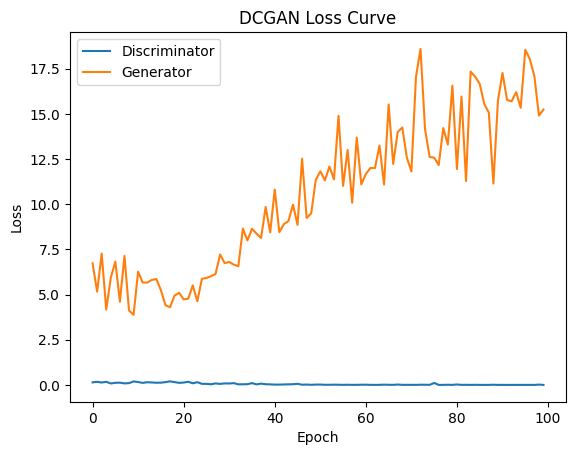

In [175]:
import matplotlib.pyplot as plt
import numpy as np

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

for epoch in range(num_epoch):  # 进行多个epoch的训练
    for i, (img, _) in enumerate(dataloader):
        for a in range(3):
            num_img = img.size(0)
            img = img.view(num_img, 1, 28, 28)
            real_img = img.to(device)
            real_label = torch.ones(num_img, 1).to(device)
            fake_label = torch.zeros(num_img, 1).to(device)

            real_out = D(real_img)
            d_loss_real = criterion(real_out, real_label)
            real_scores = real_out

            z = torch.randn(num_img, z_dimension).to(device)
            fake_img = G(z)
            fake_out = D(fake_img)
            d_loss_fake = criterion(fake_out, fake_label)
            fake_scores = fake_out

            d_loss = d_loss_real + d_loss_fake
            reset_grad()
            d_loss.backward()
            d_optimizer.step()

        z = torch.randn(num_img, z_dimension).to(device)
        fake_img = G(z)
        fake_out = D(fake_img).view(-1, 1)
        g_loss = criterion(fake_out, real_label)

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 400 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}'.format(
                epoch, num_epoch, d_loss.item(), g_loss.item(),
                torch.mean(real_scores).item(), torch.mean(fake_scores).item()
            ))

        if epoch == 0:
            real_images = to_img(real_img.cpu().data)
            save_image(real_images, './img_DCGAN/real_images.png')

        fake_images = to_img(fake_img.cpu().data)
        save_image(fake_images, './img_DCGAN/fake_images-{}.png'.format(epoch + 1))

torch.save(G.state_dict(), './generator_DCGAN.pth')
torch.save(D.state_dict(), './discriminator_DCGAN.pth')

plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.title('DCGAN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()